# Notebook 07: Convolutional Neural Networks 

### Primary Goal:

Build and train a convolutional neural network 

#### Background

Now that we have throughly discussed what a convolution is, here we will dive into training a convolutional neural network on the ```sub-sevir``` dataset. 

#### Step 1: Imports

As with all of our notebooks, first up is importing the usual packages. 

In [1]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
import matplotlib.patheffects as path_effects


#outlines for text 
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]

matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'

#### Step 2: Load in ```sub-sevir```

You'll need to update the path to where the data are you downloaded from Notebook 1. 

In [2]:
ds_train = xr.open_dataset('/Users/randyjc2/PythonWorkspace/Data/sub-sevir/sub-sevir-train.zarr',engine='zarr')
ds_val = xr.open_dataset('/Users/randyjc2/PythonWorkspace/Data/sub-sevir/sub-sevir-val.zarr',engine='zarr')

By design the ```sub-sevir``` data are 'machine learning ready'. This means that the normalization has already been done (i.e., the features have mean 0 and std 1) and the data are already split into the required groups (train/val/test). So in terms of preparing the data, we only have to pick what features we want to use and what the label is (i.e., classification/regression). 

#### Step 3: Convert data into tensors 

The only step we need to do is transistion the data from xarray to tf.datasets. This first example will be classification "Does this image contain a thunderstorm?" 

In [3]:
ds_train

<xarray.Dataset>
Dimensions:         (n_samples: 60000, x: 48, y: 48, n_channel: 4)
Coordinates:
    id              (n_samples) object ...
  * n_channel       (n_channel) <U5 'ir069' 'ir107' 'vil' 'vis'
  * n_samples       (n_samples) datetime64[ns] 2018-08-25T00:15:00 ... 2019-0...
Dimensions without coordinates: x, y
Data variables:
    features        (n_samples, x, y, n_channel) float32 ...
    label_1d_class  (n_samples) int8 ...
    label_1d_reg    (n_samples) int16 ...
    label_2d_class  (n_samples, x, y) int8 ...
    label_2d_reg    (n_samples, x, y) int16 ...

In [4]:
#make datasets 
ds_train = tf.data.Dataset.from_tensor_slices((ds_train.features.values,ds_train.label_1d_class.values))
ds_val = tf.data.Dataset.from_tensor_slices((ds_val.features.values,ds_val.label_1d_class.values))

#set random seed so we both see the same answers going forward
tf.random.set_seed(42)

#shuffle only the training
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

#batch both 
batch_size = 32
ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)

2022-12-08 12:19:11.211655: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Step 4: Reminder of ```tf.data.Datasets```

The concept of a tensorflow dataset still might be 'new' for most. Thus, I want to take a moment to describe them again. 

For the machine learning to converge in a timely matter, we estiamte how to adjust the weights of the model (i.e., the gradient of the model with respect to the error) on some random subset of the total training data (i.e., batch). There are two key aspects of that sentance, *random* and *subset*. This is accomplished in code with shuffling the data every epoch and randomly selecting batches. Tensorflow makes this easy with its tenors with the ```.shuffle()``` and ```.batch()``` methods. The code above implements both of those methods. 


Frequently asked question: "How do I look at my data in these ```tf.data.Dataset```?"

if you print out this variable it doesn't show you much 

In [5]:
ds_train

<BatchDataset shapes: ((None, 48, 48, 4), (None,)), types: (tf.float32, tf.int8)>

The shape information is useful, but not what you want when you want to look at the data. The numbers above are ```(None, 48,48,4)``` The ```None``` might be confusing, but this is the batch dimension, which we set to 32 above. The other dimensions are the 48 x-pixels, 48 y-pixels and 4 variables (i.e., channels). Then our label is just of the shape ```None``` which is either 1 or 0 depending on if the image has lightning in it. 

To get a batch, we can *iterate* over this dataset. The following code will loop once, to get the first batch. 

In [6]:
for batch in ds_train:
    break 

In [7]:
batch

(<tf.Tensor: shape=(32, 48, 48, 4), dtype=float32, numpy=
 array([[[[ 6.93003118e-01,  1.29607499e+00, -2.06395701e-01,
           -4.76107270e-01],
          [ 6.66918874e-01,  1.24724758e+00, -2.06395701e-01,
           -4.95039463e-01],
          [ 6.16433203e-01,  1.26972377e+00, -2.06395701e-01,
           -5.44263005e-01],
          ...,
          [-5.85124910e-01, -6.91892385e-01, -2.06395701e-01,
            1.07727516e+00],
          [-4.26936805e-01, -4.88832980e-01, -2.06395701e-01,
            8.44883144e-01],
          [ 1.21673852e-01,  5.98542571e-01, -2.06395701e-01,
           -6.10200316e-02]],
 
         [[ 6.57663167e-01,  1.13254237e+00, -2.06395701e-01,
           -2.03011125e-01],
          [ 6.30737484e-01,  1.19415772e+00, -2.06395701e-01,
           -5.18704653e-01],
          [ 6.10543251e-01,  1.26739872e+00, -2.06395701e-01,
           -5.26750803e-01],
          ...,
          [-7.13863552e-01, -8.10085356e-01, -2.06395701e-01,
            1.12697208e+00],

Now you can see that batch is a *tuple* of the images and the labels, containing 32 of them. Nice right? We can visualize just one example to show the whole proccess:

<tf.Tensor: shape=(), dtype=int8, numpy=0>

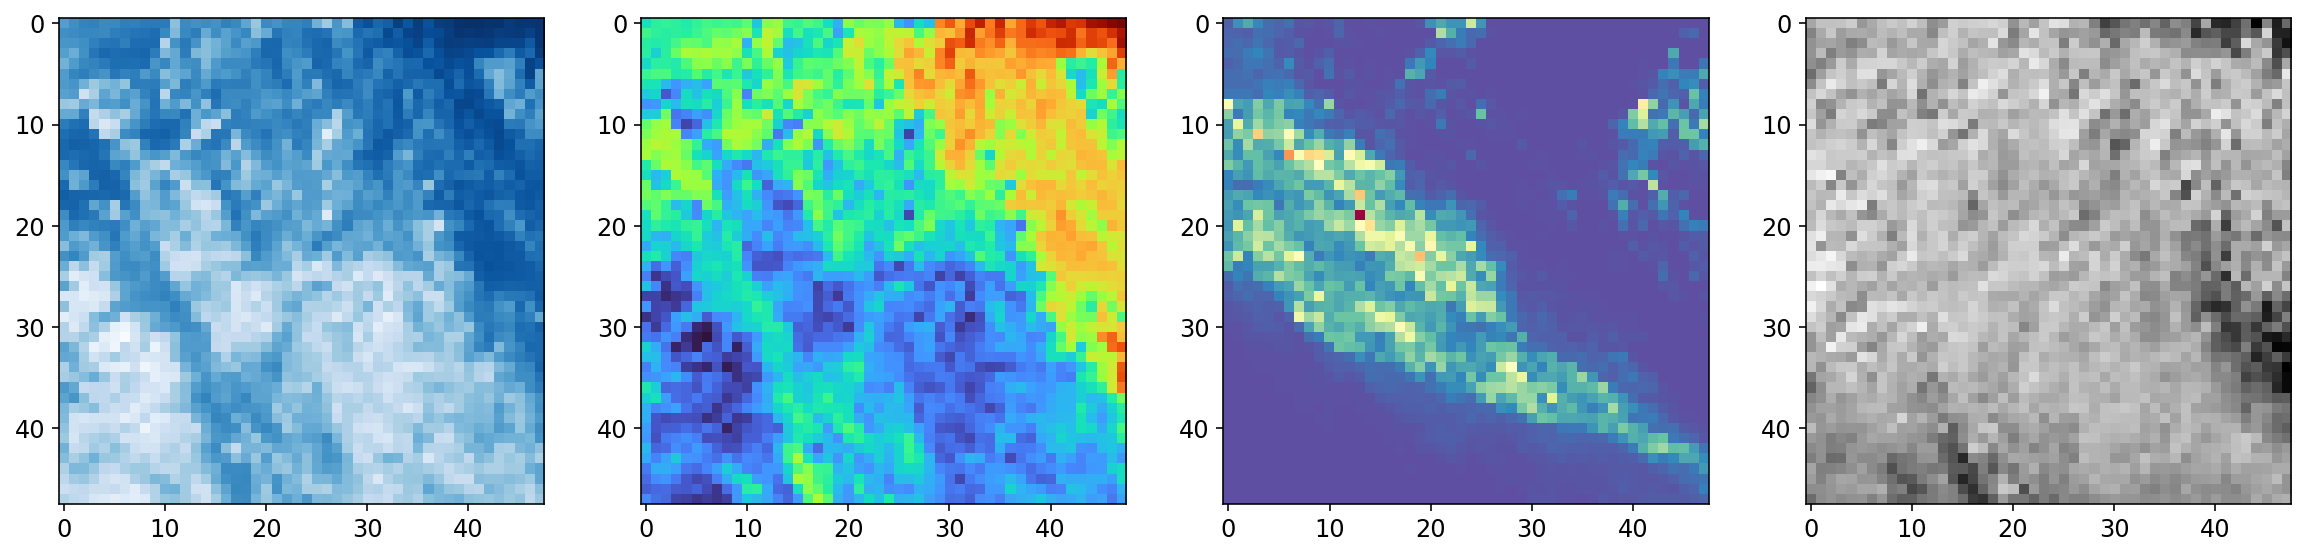

In [8]:
#get the features for example 12 in this batch 
one_example_features = batch[0][12]
#get the label for that same example 
one_example_label = batch[1][12]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

one_example_label

there ya go! Now you have a way to dig into the data when they are in this tf.data.Dataset form. 

Just know that if you iterate this dataset again, you will get a new example for the same index... 

<tf.Tensor: shape=(), dtype=int8, numpy=0>

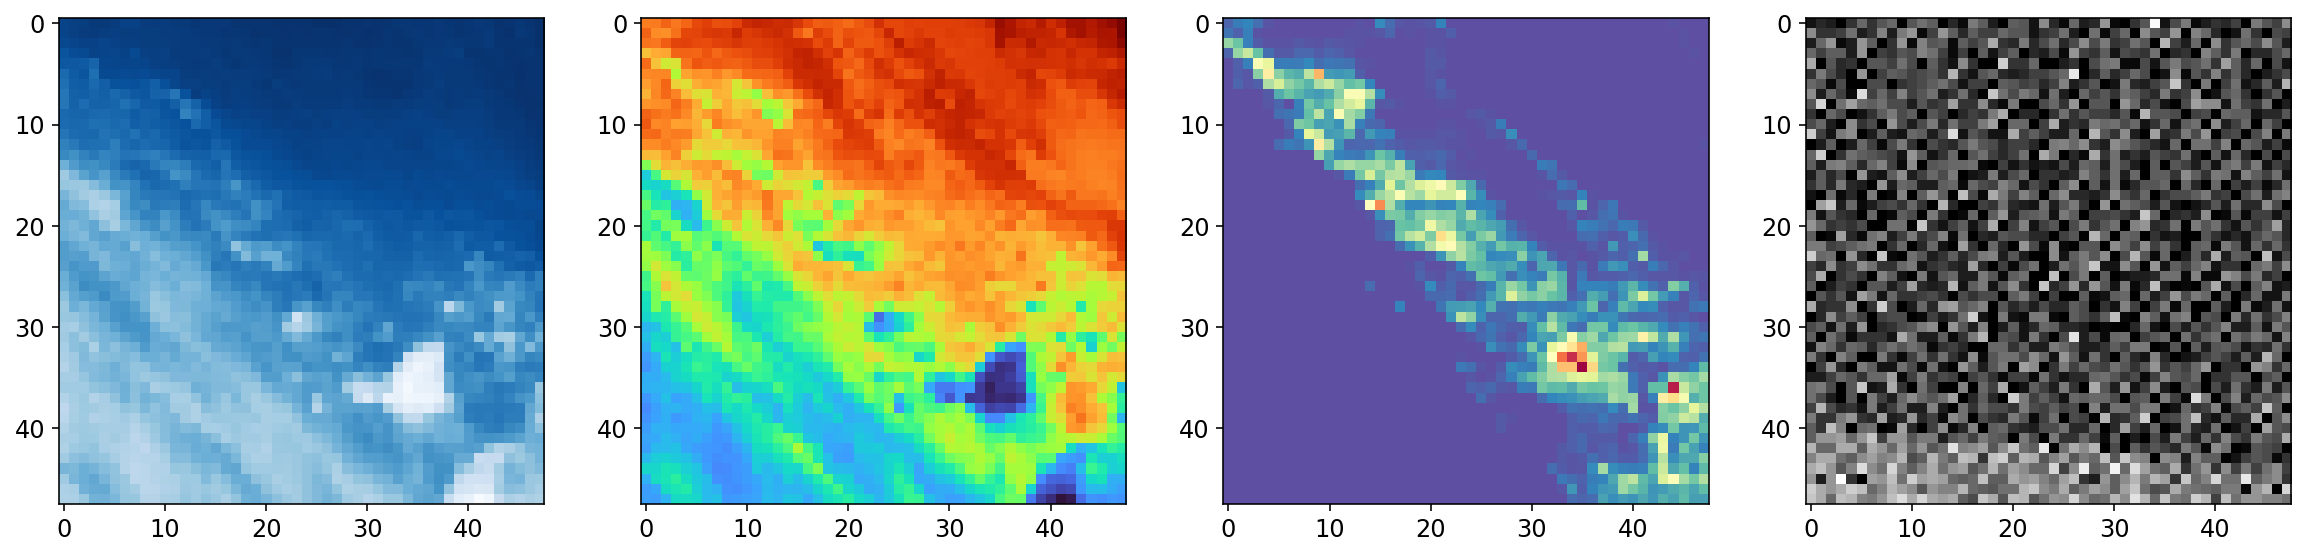

In [9]:
for batch in ds_train:
    break 
    
#get the features for example 12 in this batch 
one_example_features = batch[0][12]
#get the label for that same example 
one_example_label = batch[1][12]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

one_example_label

#### Step 5: Build CNN model

Just like Notebook 5 (the ANNs) we can use the same sequential model to build our CNN. 

Let's start simple and make the following: 

1) single convolutional layer with 3x3 filters, and 1 output map. 


In [10]:
model = tf.keras.models.Sequential([
        #input layer 
        tf.keras.layers.Conv2D(1,kernel_size=3,activation='relu',input_shape=(ds_train.element_spec[0].shape[1:]),),
    
        #need to flatten/ravel the 2d image into a 1d vector 
        tf.keras.layers.Flatten(),
        
        #output layer (apply sigmoid because binary classification
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 1)         37        
                                                                 
 flatten (Flatten)           (None, 2116)              0         
                                                                 
 dense (Dense)               (None, 1)                 2117      
                                                                 
Total params: 2,154
Trainable params: 2,154
Non-trainable params: 0
_________________________________________________________________


#### Step 6: Run some data through

It might be good to run your data through to see how the model does with completely random weights. 

(0.0, 1.0)

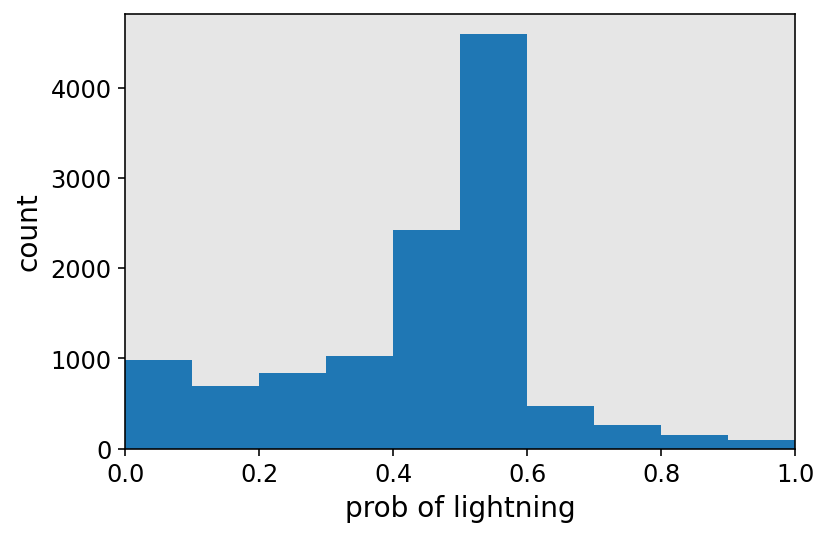

In [11]:
#like sklearn, we do .predict!
y_preds = model.predict(ds_val)

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])

As expected, the model is producing predictions [0,1] and is generally in the middle of the distribution. 

Lets take a look at the performance diagram. To do that, we need the truth label as a vector instead of the ```tf.data.Dataset```, so lets quick grab that data since we clobbered the variable ```ds_val```

In [12]:
y_v = np.array([])
for _,y in ds_val:
    y_v = np.append(y_v,y)


In [13]:
#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v,y_preds)
fps = fp(y_v,y_preds)
fns = fn(y_v,y_preds)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)

posx and posy should be finite values
posx and posy should be finite values


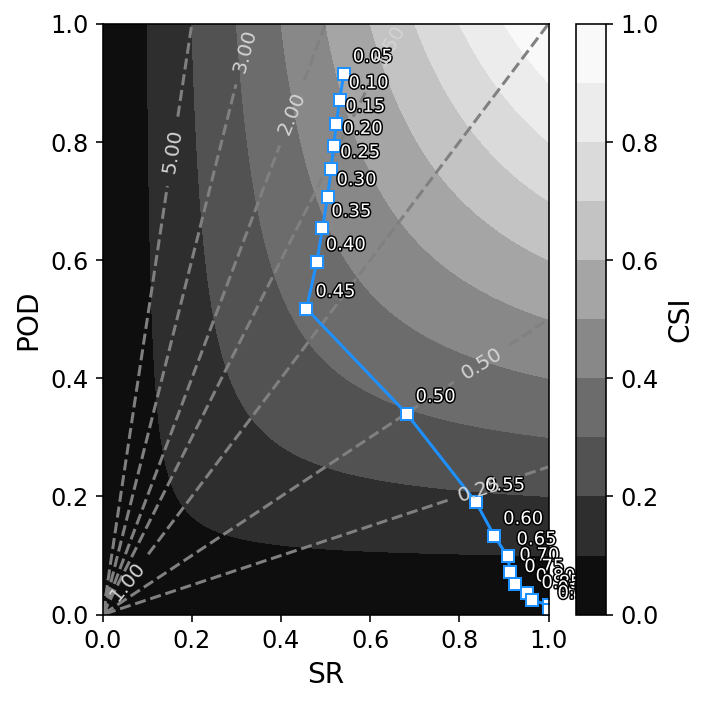

In [14]:
#import some helper functions for our other directory.
import sys
sys.path.insert(1, '../scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
    ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,path_effects=pe1,fontsize=9,color='white')

plt.tight_layout()

Some funky things to note with this performance diagram. It might seem like random weights work well, but remember this dataset is roughtly balanced, (no lightning: 44%; lightning 56%), so random guess will give decent performance, so don't be mis-lead here. Also notice how the curve seems disjoint, almost like there is an inflection point for the probability value of 0.45, this is not a good behavior for this diagram. 

If you want to view the convolution filters you can see them by doing the following. 

In [15]:
#grab layer 1 weights, which are the convolution filters. 
filters = model.weights[0]

filters.shape

TensorShape([3, 3, 4, 1])

lets take a look at each of them. Notice we have one for each feature (dims are [x,y,variable,output])

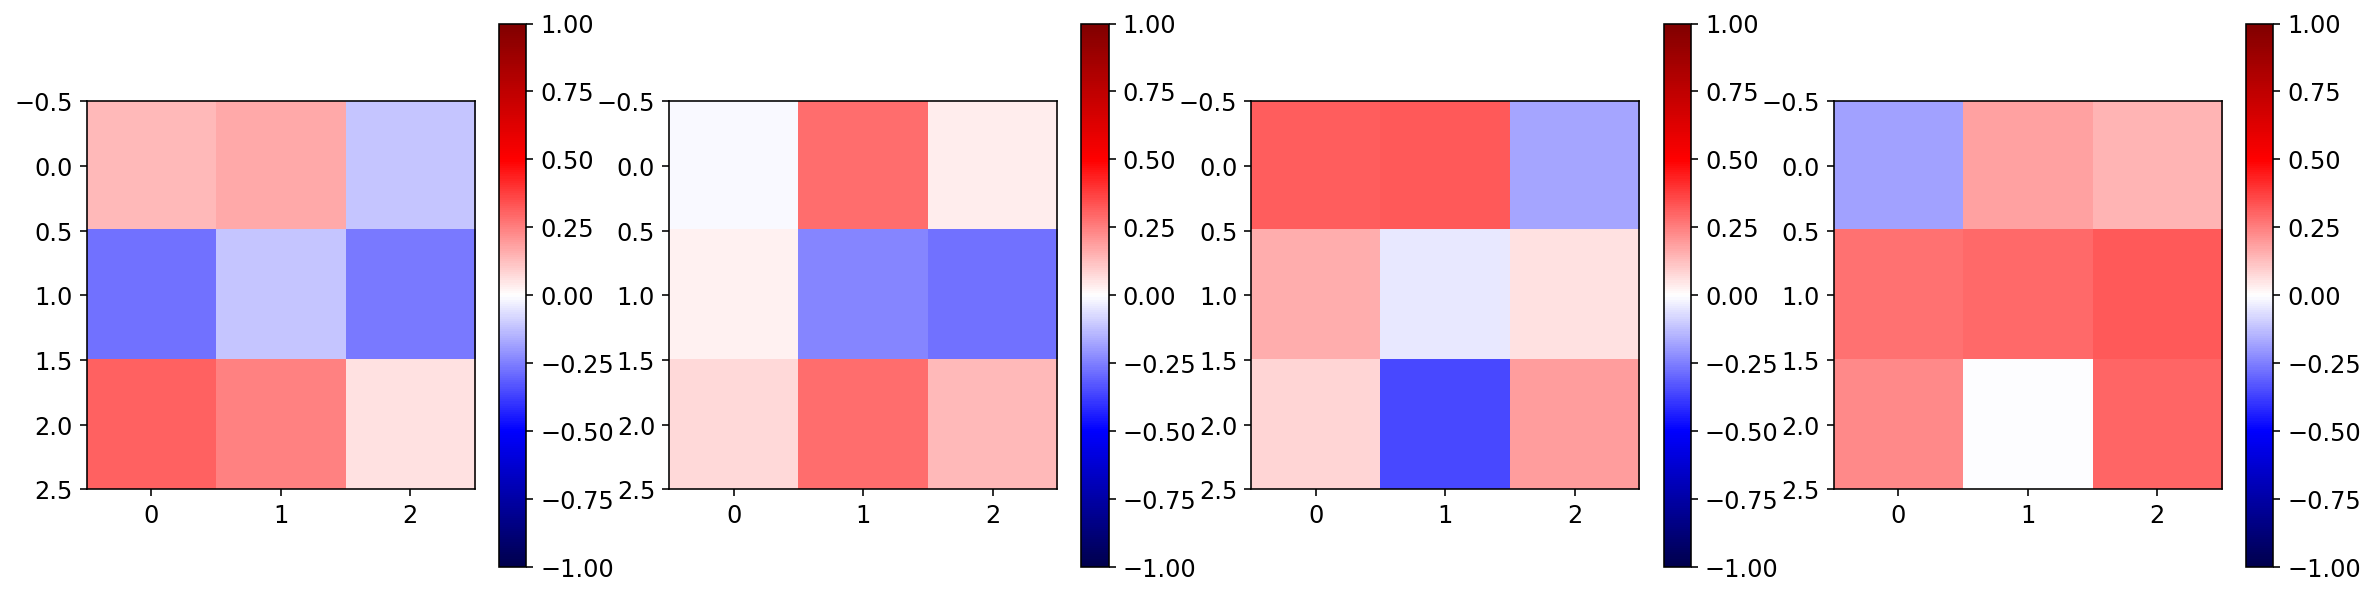

In [16]:
fig,axes = plt.subplots(1,4,figsize=(20,5))

for i in np.arange(0,4):
    pm = axes[i].imshow(filters[:,:,i,0],vmin=-1,vmax=1,cmap='seismic')
    plt.colorbar(pm,ax=axes[i])
    

This really isn't informative, but you can see how the values are sorta equally distributed around 0. Which is should be from the initialzation step. 

Maybe looking at the output of the convolutional layer will help? Tensorflow/keras lets us output specific layers by doing the following:

- first we need to print out the layer names


In [17]:
for l,layer in enumerate(model.layers):
    print(l,layer.name)

0 conv2d
1 flatten
2 dense


For our simple model, the convolution layer name is ```conv2d```, so we will use that *key* to grab the link to that layer and build a new model to just output that layer

In [18]:
#identify the convolutional layer
conv_layer = model.get_layer('conv2d')

#re-wire a model to take the normal model inputs, but now just output the result of the convolution
conv_output = tf.keras.models.Model([model.inputs], [conv_layer.output])

#run the model the same way, to see what the output convovled image
convolved_images = conv_output.predict(ds_val)

#grab a batch to look at 
for batch in ds_val:
    break 

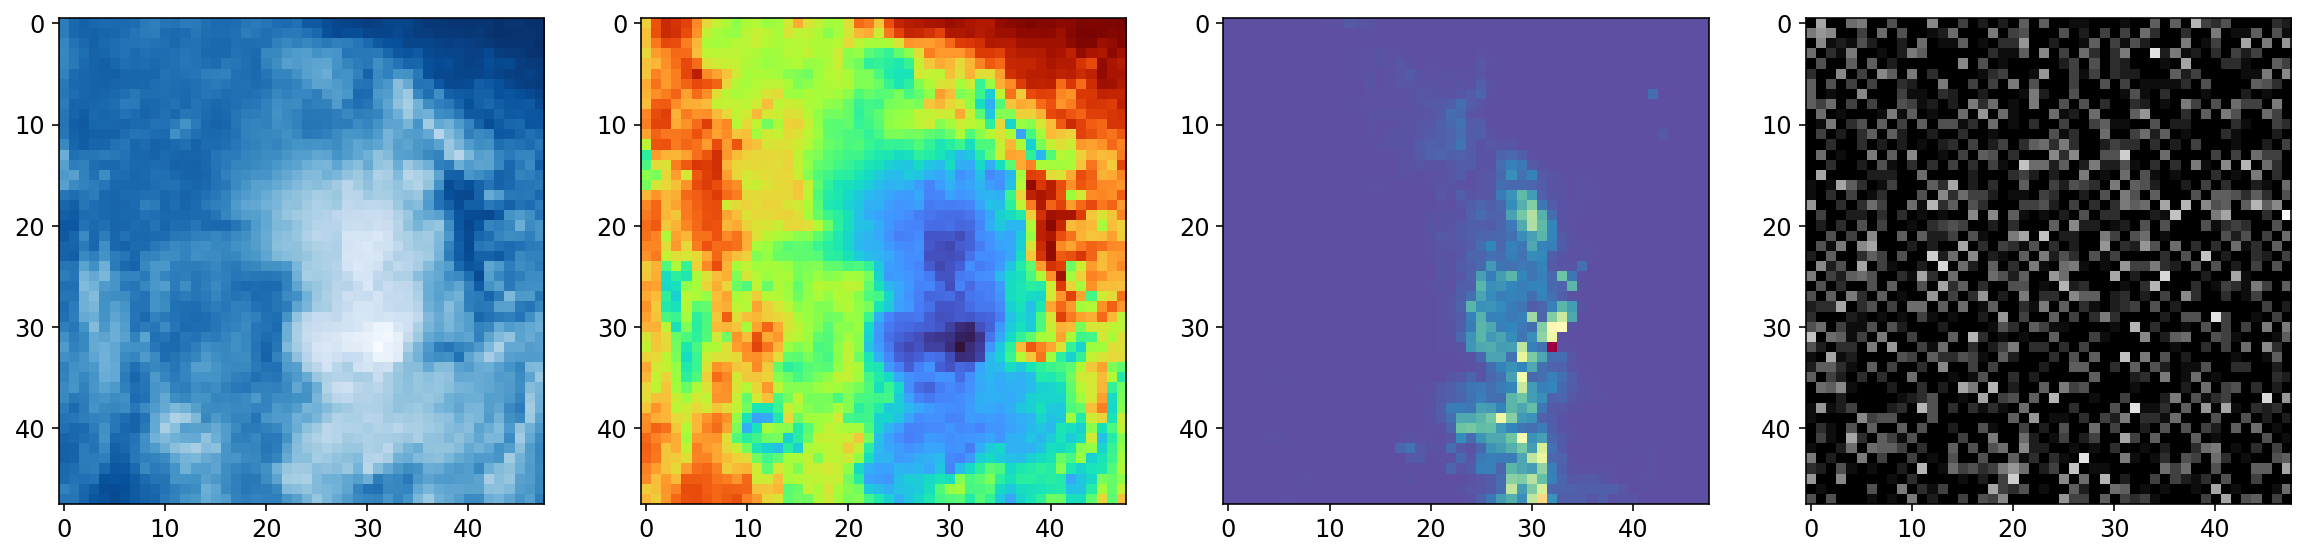

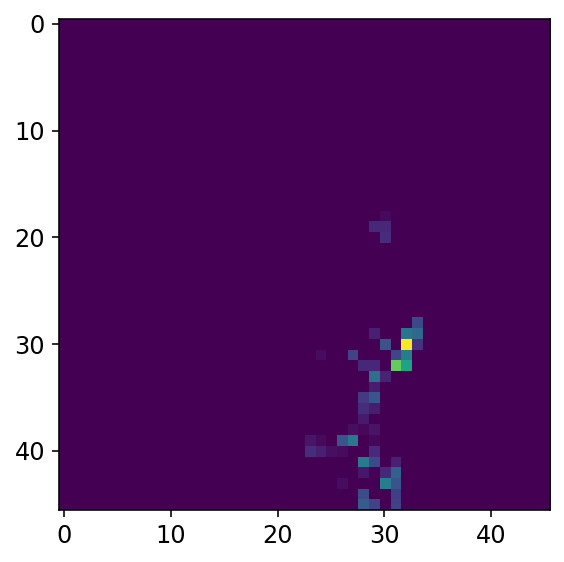

In [19]:
#get the features for example 12 in this batch 
one_example_features = batch[0][0]
#get the label for that same example 
one_example_label = batch[1][0]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

one_example_label


plt.figure(figsize=(4.4,5))
plt.imshow(convolved_images[0])

This is somewhat more informative than looking at the filter kernels, but notice that even for completely random filter weights (i.e., no training), the CNN still highlights the region where a storm is. This is probably why the performance diagram looks decent.

#### Step 7: Train the model for 10 epochs

Okay, enough of digging in the weeds. Let's compile and train the model

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3))

history = model.fit(ds_train,validation_data=ds_val,epochs=20)

Epoch 1/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.4264 - val_loss: 0.3262
Epoch 2/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3031 - val_loss: 0.3102
Epoch 3/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2925 - val_loss: 0.3083
Epoch 4/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2900 - val_loss: 0.2959
Epoch 5/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2896 - val_loss: 0.3050
Epoch 6/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2877 - val_loss: 0.2943
Epoch 7/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2862 - val_loss: 0.3066
Epoch 8/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2864 - val_loss: 0.3153
Epoch 9/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2873 - val_loss: 0.2956
Epoch 10/20
1875/1875 [==============================] - 12s 6ms/step - l

depeneding on your computer, this might take some time to run.

#### Step 8: Check for overfitting

Okay, as always, we should probably check to see if the model is overfitting. To do this, lets plot the loss curves for both the training data and the validation data

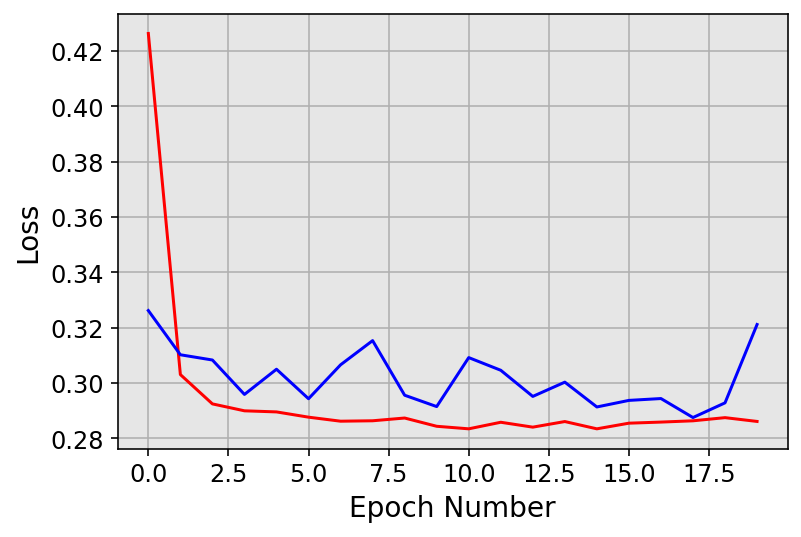

In [36]:
plt.plot(history.history['loss'],'-r')
plt.plot(history.history['val_loss'],'-b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()

Take a moment and consider if overfitting has occured? Remember you are looking to see here if the red line continues to decrease while the blue line increases. 

For this example, I would say that is has probably begun to overfit , around epoch 17 this is where things progressively get workse for 3 epochs. But, lets check on the overall performance anyway

#### Step 9: Check performance

To check perfomance I grabbed the same blocks of code from before where we sent data throught the model

(0.0, 1.0)

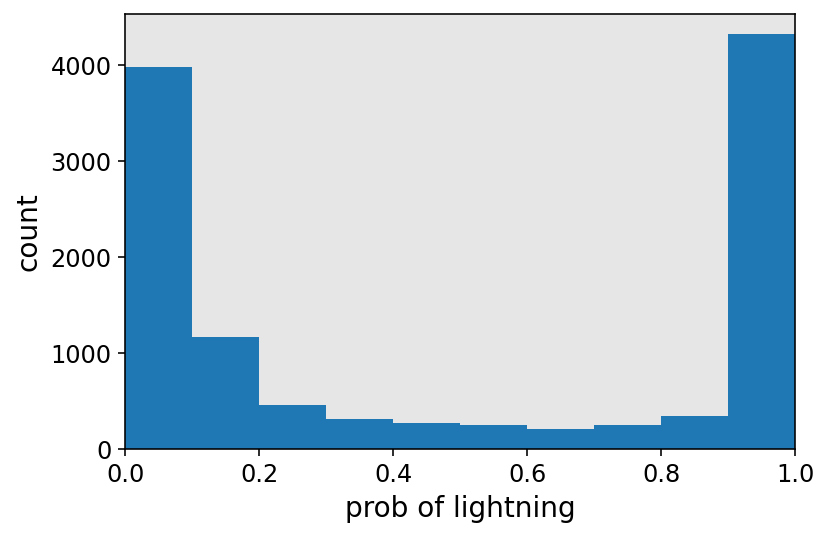

In [37]:
#like sklearn, we do .predict!
y_preds = model.predict(ds_val)

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])

Here we can now see there is a good grouping of examples where the model predicts near 0 and near 1, and then there is some cases where the output of the model is more in the middle (i.e., more uncertain). 

Let's make the performance diagram again

In [40]:
#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v,y_preds)
fps = fp(y_v,y_preds)
fns = fn(y_v,y_preds)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)

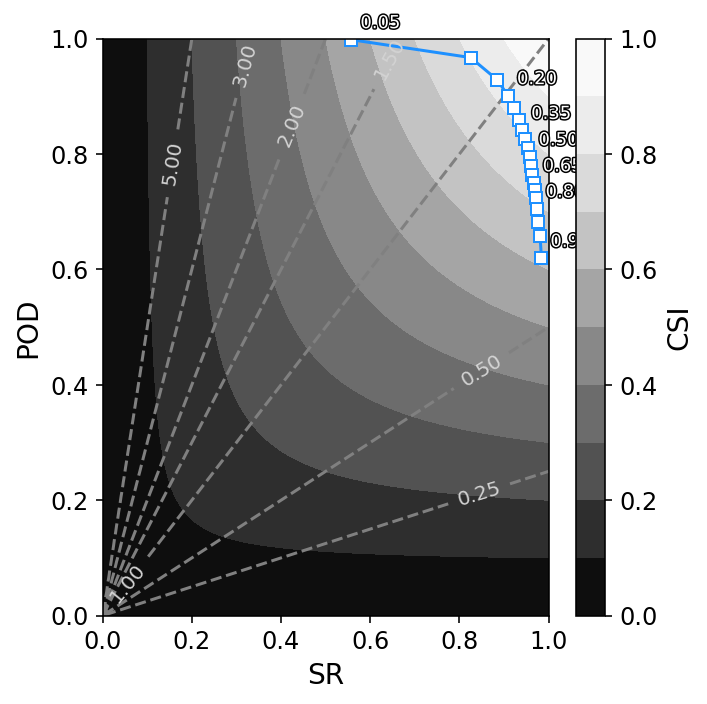

In [41]:
#import some helper functions for our other directory.
import sys
sys.path.insert(1, '../scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    if np.mod(i,3)==0:
        text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
        ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,path_effects=pe1,fontsize=9,color='white')

plt.tight_layout()

Ah much better results this time. Peak CSI values of above 0.8 come from a probability of 0.2.

Can we see what filter it learned?

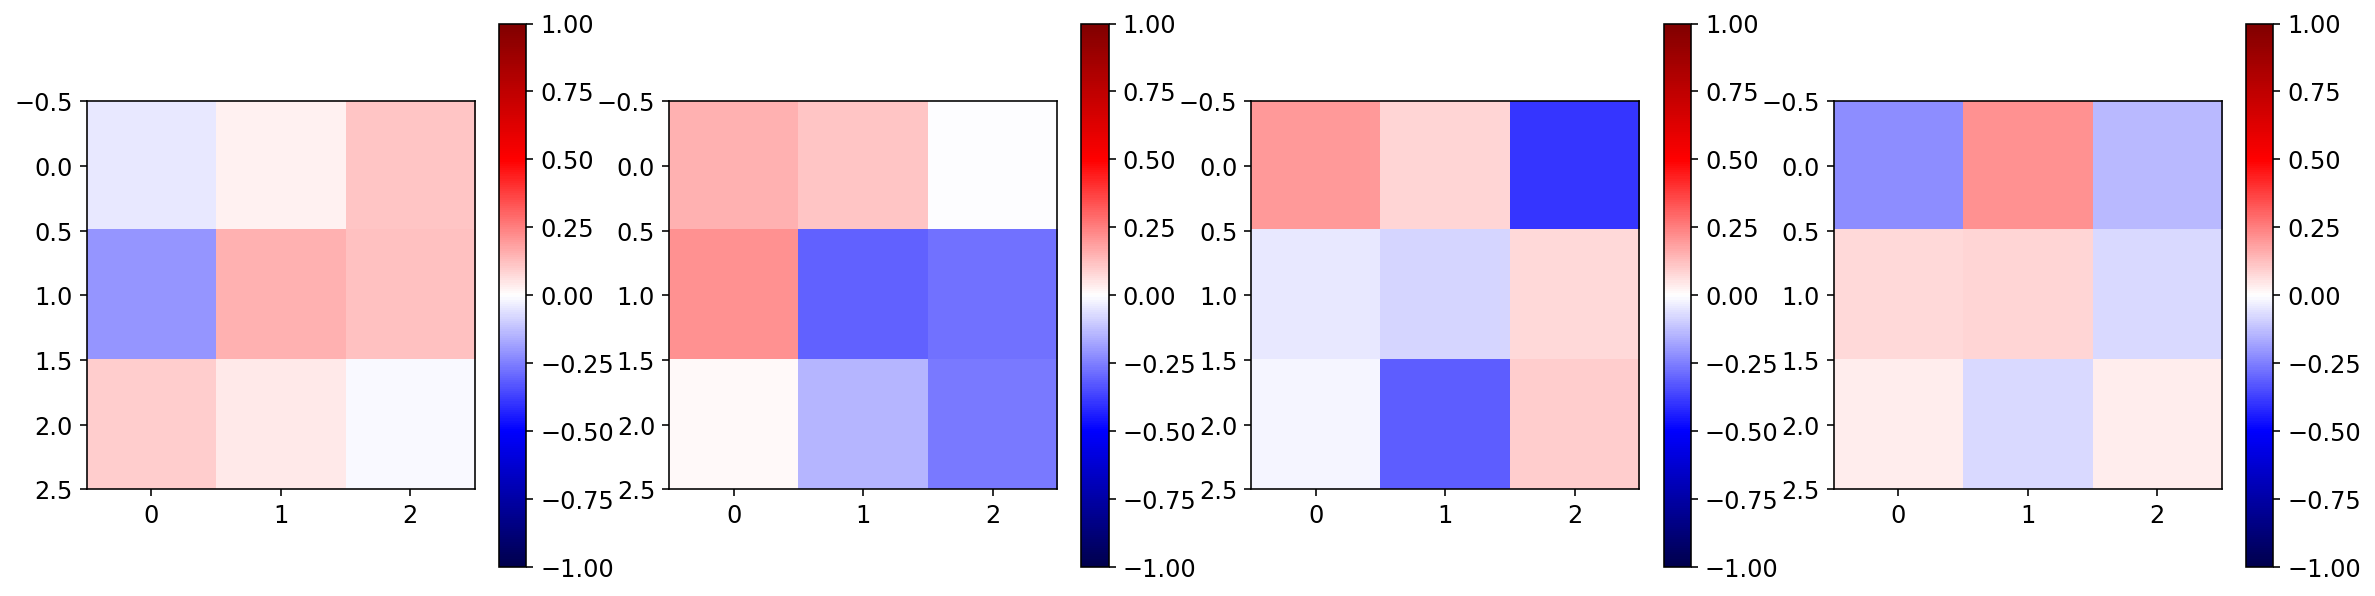

In [42]:
#grab layer 1 weights, which are the convolution filters. 
filters = model.weights[0]

filters.shape

fig,axes = plt.subplots(1,4,figsize=(20,5))

for i in np.arange(0,4):
    pm = axes[i].imshow(filters[:,:,i,0],vmin=-1,vmax=1,cmap='seismic')
    plt.colorbar(pm,ax=axes[i])

Hmm as before it doesn't seem to useful to look at the kernels themselves, so lets look at the output of the convolutional layer with the same example we showed before

In [43]:
#identify the convolutional layer
conv_layer = model.get_layer('conv2d')

#re-wire a model to take the normal model inputs, but now just output the result of the convolution
conv_output = tf.keras.models.Model([model.inputs], [conv_layer.output])

#run the model the same way, to see what the output convovled image
convolved_images = conv_output.predict(ds_val)

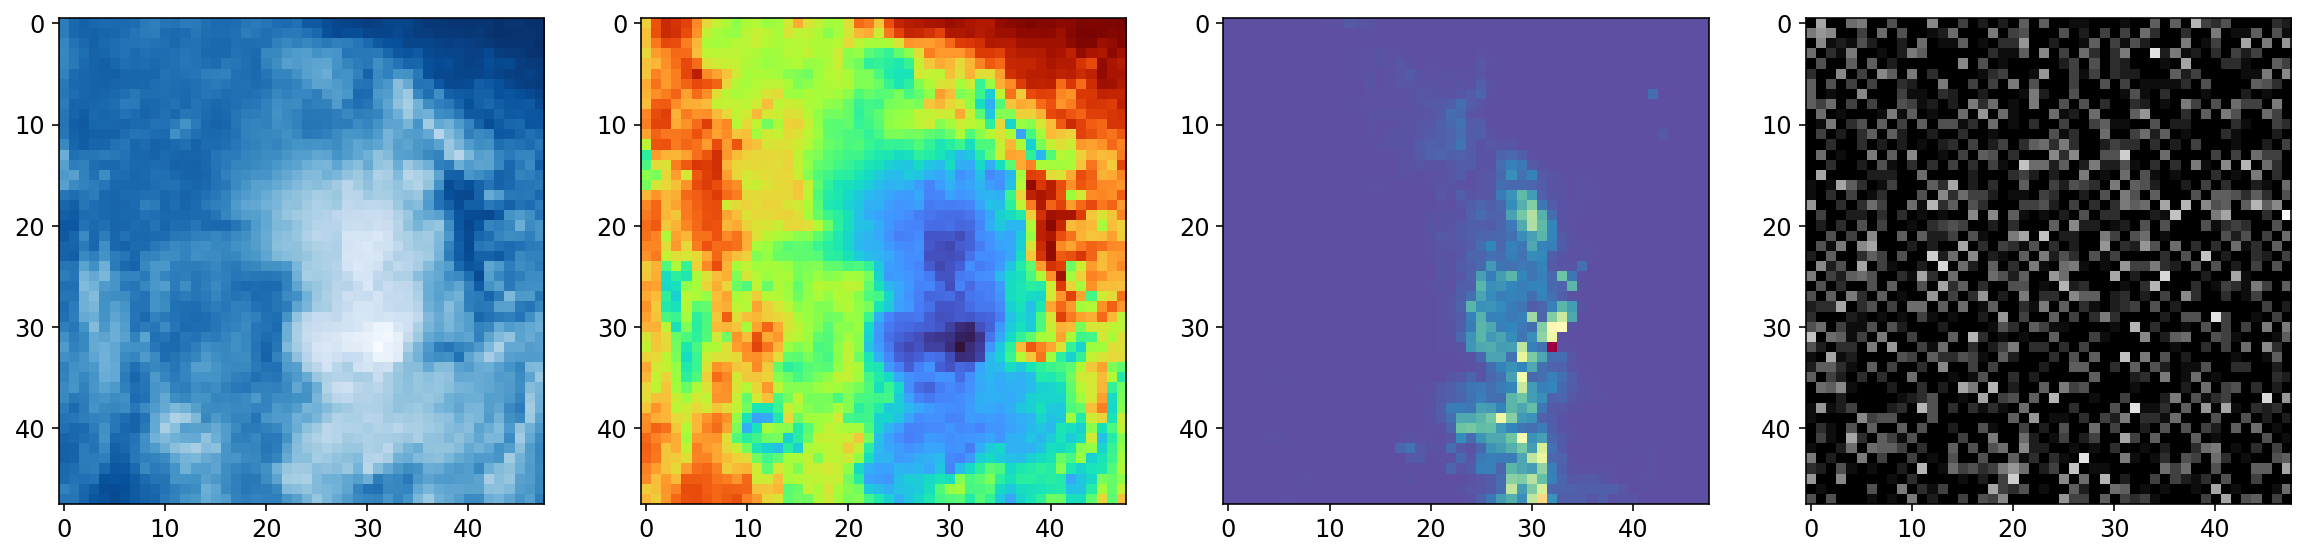

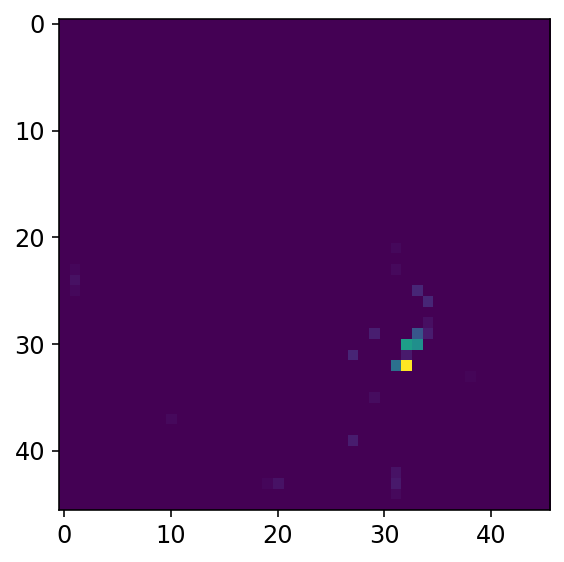

In [44]:
#get the features for example 12 in this batch 
one_example_features = batch[0][0]
#get the label for that same example 
one_example_label = batch[1][0]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

one_example_label


plt.figure(figsize=(4.4,5))
plt.imshow(convolved_images[0])

The result here is actually quite similar to the untrained model. Although, the convolved data looks a bit more 'focused' in on the area where there are cold cloud tops and high radar values. 

This is hopefully not very satisfying to you in 'explaining' the trained models behavior. Thus, later on in this tutorial series there is a notebook discussing some more quantitative methods for explaining the CNN.

The next notebook will dive into using U-nets, such that we can not only classify if there is lighting in this image, we can have the U-net tell us where the lightning is. 